
#### based on Fig. B1 from Spichtinger et al. 2023 (ACP)  "_Impact of formulations of the homogeneous nucleation rate on ice nucleation events in cirrus_"

(work in progress)

https://doi.org/10.5194/acp-23-2035-2023

In [1]:
import sys
if 'google.colab' in sys.modules:
    !pip --quiet install open-atmos-jupyter-utils
    from open_atmos_jupyter_utils import pip_install_on_colab
    pip_install_on_colab('PySDM-examples')

In [2]:
import json
from PySDM_examples.Spichtinger_et_al_2023 import Simulation, Settings
from PySDM_examples.Spichtinger_et_al_2023.data import simulation_data, reference_bulk
import numpy as np
from matplotlib import pyplot
from open_atmos_jupyter_utils import show_plot

In [3]:
calculate_data = False
save_to_file = False
read_from_json = False

In [4]:
if calculate_data:

    initial_temperatures = np.array([196.0, 216.0, 236.0])
    updrafts = np.array([0.01, 0.03, 0.05, 0.1, 0.3, 0.5, 1.0, 3.0, 5.0])
    number_of_ensemble_runs = 5
    seeds = [124670285330, 439785398735, 9782539783258, 12874192127481, 12741731272]

    dim_updrafts = len(updrafts)
    dim_initial_temperatures = len(initial_temperatures)

    number_concentration_ice = np.zeros(
        [dim_updrafts, dim_initial_temperatures, number_of_ensemble_runs]
    )

    for i in range(dim_updrafts):
        for j in range(dim_initial_temperatures):
            for k in range(number_of_ensemble_runs):
                setting = Settings(n_sd=50000,
                                   w_updraft=updrafts[i],
                                   T0=initial_temperatures[j],
                                   seed=seeds[k],
                                   dt=0.1)
                model = Simulation(setting)
                number_concentration_ice[i, j, k] = model.run()

    if save_to_file:
        file_name = "data/ni_w_T_ens_" + str(number_of_ensemble_runs) + ".json"
        data_file = {
            "ni": number_concentration_ice.tolist(),
            "T": initial_temperatures.tolist(),
            "w": updrafts.tolist(),
        }
        with open(file_name, "w", encoding="utf-8") as file:
            json.dump(data_file, file)

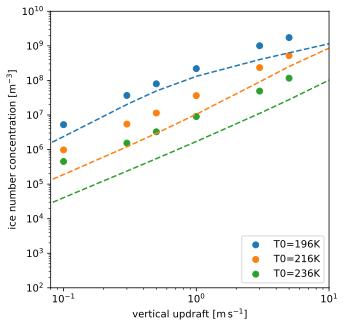

In [5]:
if calculate_data:
    T = initial_temperatures
    w = updrafts
    ni_ens_mean = np.mean(number_concentration_ice, axis=2)
else:
    if read_from_json:
        file_name = "data/ni_w_T_ens_5.json"
        with open(file_name, "r", encoding="utf-8") as f:
            data = json.load(f)

        ni = data["ni"]
        T = data["T"]
        w = data["w"]
        ni_ens_mean = np.mean(ni, axis=2)
    else:
        T, w, ni_ens_mean = simulation_data.saved_simulation_ensemble_mean()

# bulk reference
T_bulk_ref, w_bulk_ref, ni_bulk_ref = reference_bulk.bulk_model_reference_array()

# plot
fig, ax = pyplot.subplots(1, 1, figsize=(5, 5))

for j, Tj in enumerate(T):
    ax.scatter(w, ni_ens_mean[:, j], label=f"T0={Tj:.0f}K")
    ax.plot(w_bulk_ref, ni_bulk_ref[j, :], linestyle="dashed")

ax.set_xscale("log")
ax.set_xlim(0.08, 10.0)
ax.set_xlabel(r"vertical updraft [$\mathrm{m \, s^{-1}}$]")

ax.set_yscale("log")
ax.set_ylim(1.0e2, 1.0e10)
ax.set_ylabel(r"ice number concentration [$\mathrm{m^{-3}}$]")

ax.legend(loc="lower right")

show_plot('fig_B1.pdf')